In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM2D import TMCRBM2D
from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

f = h5py.File("../model/AllParametersTMC2DRBM_NGibbs_30_Nh100_Nv1000_Nmb200_Nepoch100_lr_0.1_N20000_Npoint2500_Nchain10.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
print(alltimes)
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 22, 24, 25, 26, 28, 32, 38, 41, 42, 43, 45, 48, 49, 55, 65, 69, 70, 71, 73, 77, 82, 83, 93, 110, 118, 119, 120, 122, 126, 132, 138, 142, 159, 187, 201, 202, 203, 205, 209, 215, 225, 236]


In [2]:
t = 110
lr = 0.01
NGibbs = 30
annSteps = 0
mb_s = 600
num_pcd = 600
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 20

myRBM = TMCRBM2D(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
myRBM.p_m = torch.tensor(f['p_m'+str(t)], device = myRBM.device)
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_data = torch.mm(data, V_g).cpu()/myRBM.Nv**.5
width_plus = .2
xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus

In [3]:
h_pos_v, h_pos_m = myRBM.SampleHiddens01(data.T)

s = time.time()

# SVD des poids
_, _, myRBM.V0 = torch.svd(myRBM.W)
if torch.mean(myRBM.V0[:,0]) < 0:
    myRBM.V0 = -myRBM.V0

# pour adapter la taille de l'intervalle discrétisé à chaque itération
proj_data = torch.mm(data, myRBM.V0)/myRBM.Nv**.5
width_plus = 0.2
limits = torch.zeros((2, myRBM.nDim))
for i in range(myRBM.nDim):
    limits[0, i] = proj_data[:,i].min()-width_plus
    limits[1, i] = proj_data[:,i].max()+width_plus
x_grid = np.linspace(limits[0,0], limits[1,0], myRBM.nb_point_dim[0])
x_grid = np.array([x_grid for i in range(myRBM.nb_point_dim[1])])
x_grid = x_grid.reshape(myRBM.nb_point)
y_grid = []
y_d = np.linspace(limits[0,1], limits[1,1], myRBM.nb_point_dim[1])
for i in range(myRBM.nb_point_dim[1]):
    for j in range(myRBM.nb_point_dim[0]):
        y_grid.append(y_d[i])
myRBM.w_hat_b = torch.tensor([x_grid, y_grid], device = myRBM.device, dtype = myRBM.dtype)

start = torch.bernoulli(torch.rand(myRBM.Nv, myRBM.nb_chain*myRBM.nb_point, device = myRBM.device))
w_hat = torch.zeros((myRBM.nDim, myRBM.nb_chain*myRBM.nb_point), device = myRBM.device)
for i in range(myRBM.nb_point):
    for j in range(myRBM.nb_chain):
        w_hat[:,i*myRBM.nb_chain+j] = myRBM.w_hat_b[:,i]

print("Initialisation time : ", time.time()-s)

s=time.time()

tmpv, tmph, vtab = myRBM.TMCSample(start, w_hat, myRBM.N, myRBM.V0, it_mcmc = myRBM.gibbs_steps, it_mean=myRBM.it_mean)

print("Sampling time : ", time.time()-s)

newy = torch.mm(torch.mean(vtab, dim = 2).T, myRBM.V0)[:,:myRBM.nDim]/myRBM.Nv**0.5
grad_pot = newy.T-myRBM.w_hat_b
square = torch.zeros(2, myRBM.nb_point_dim[0], myRBM.nb_point_dim[1])
w_hat_tmp = np.zeros((2, myRBM.nb_point_dim[0], myRBM.nb_point_dim[1]))
for i in range(0,grad_pot.shape[1], myRBM.nb_point_dim[0]):
        w_hat_tmp[:,:,int(i/myRBM.nb_point_dim[0])] = myRBM.w_hat_b[:, i:(i+myRBM.nb_point_dim[0])].cpu().numpy()
        square[:,:, int(i/myRBM.nb_point_dim[0])] = grad_pot[:,i:(i+myRBM.nb_point_dim[0])]

w_hat_dim = []
for i in range(myRBM.nDim):
    w_hat_dim.append(np.linspace(limits[0,i], limits[1,i], myRBM.nb_point_dim[i]))

res_x = np.zeros(myRBM.nb_point_dim[0])
for i in range(myRBM.nb_point_dim[0]):
    res_x[i] = simps(square[0][:(i+1),0].cpu().numpy(), w_hat_tmp[0,:(i+1),0])
res_y = np.zeros((myRBM.nb_point_dim[0], myRBM.nb_point_dim[1]))
for i in range(myRBM.nb_point_dim[0]):
    for j in range(myRBM.nb_point_dim[1]):
        res_y[i,j] = simps(square[1][i,:(j+1)].cpu().numpy(), w_hat_tmp[1,i,:(j+1)])

pot = np.expand_dims(res_x, 1).repeat(myRBM.nb_point_dim[1].cpu(),1) + res_y    
res = np.exp(myRBM.N*(pot-np.max(pot)))

const = np.zeros(res.shape[0])
for i in range(res.shape[0]):
    const[i-1] = simps(res[:,i], w_hat_tmp[1, i, :])
const = simps(const, w_hat_tmp[0,:,0])
myRBM.p_m = torch.tensor(res/const, device=myRBM.device, dtype=myRBM.dtype)


Initialisation time :  1.7666923999786377
Sampling time :  33.59562540054321


In [4]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 10000), device=myRBM.device, dtype=myRBM.dtype))
#vinit = torch.where(V_g[:,0]>0, 1, 0).repeat(2000).reshape(myRBM.Nv, 2000).float()
#vinit = data.T
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=1000)
proj_gen = torch.mm(si.T, V_g).cpu().numpy()/Nv**.5

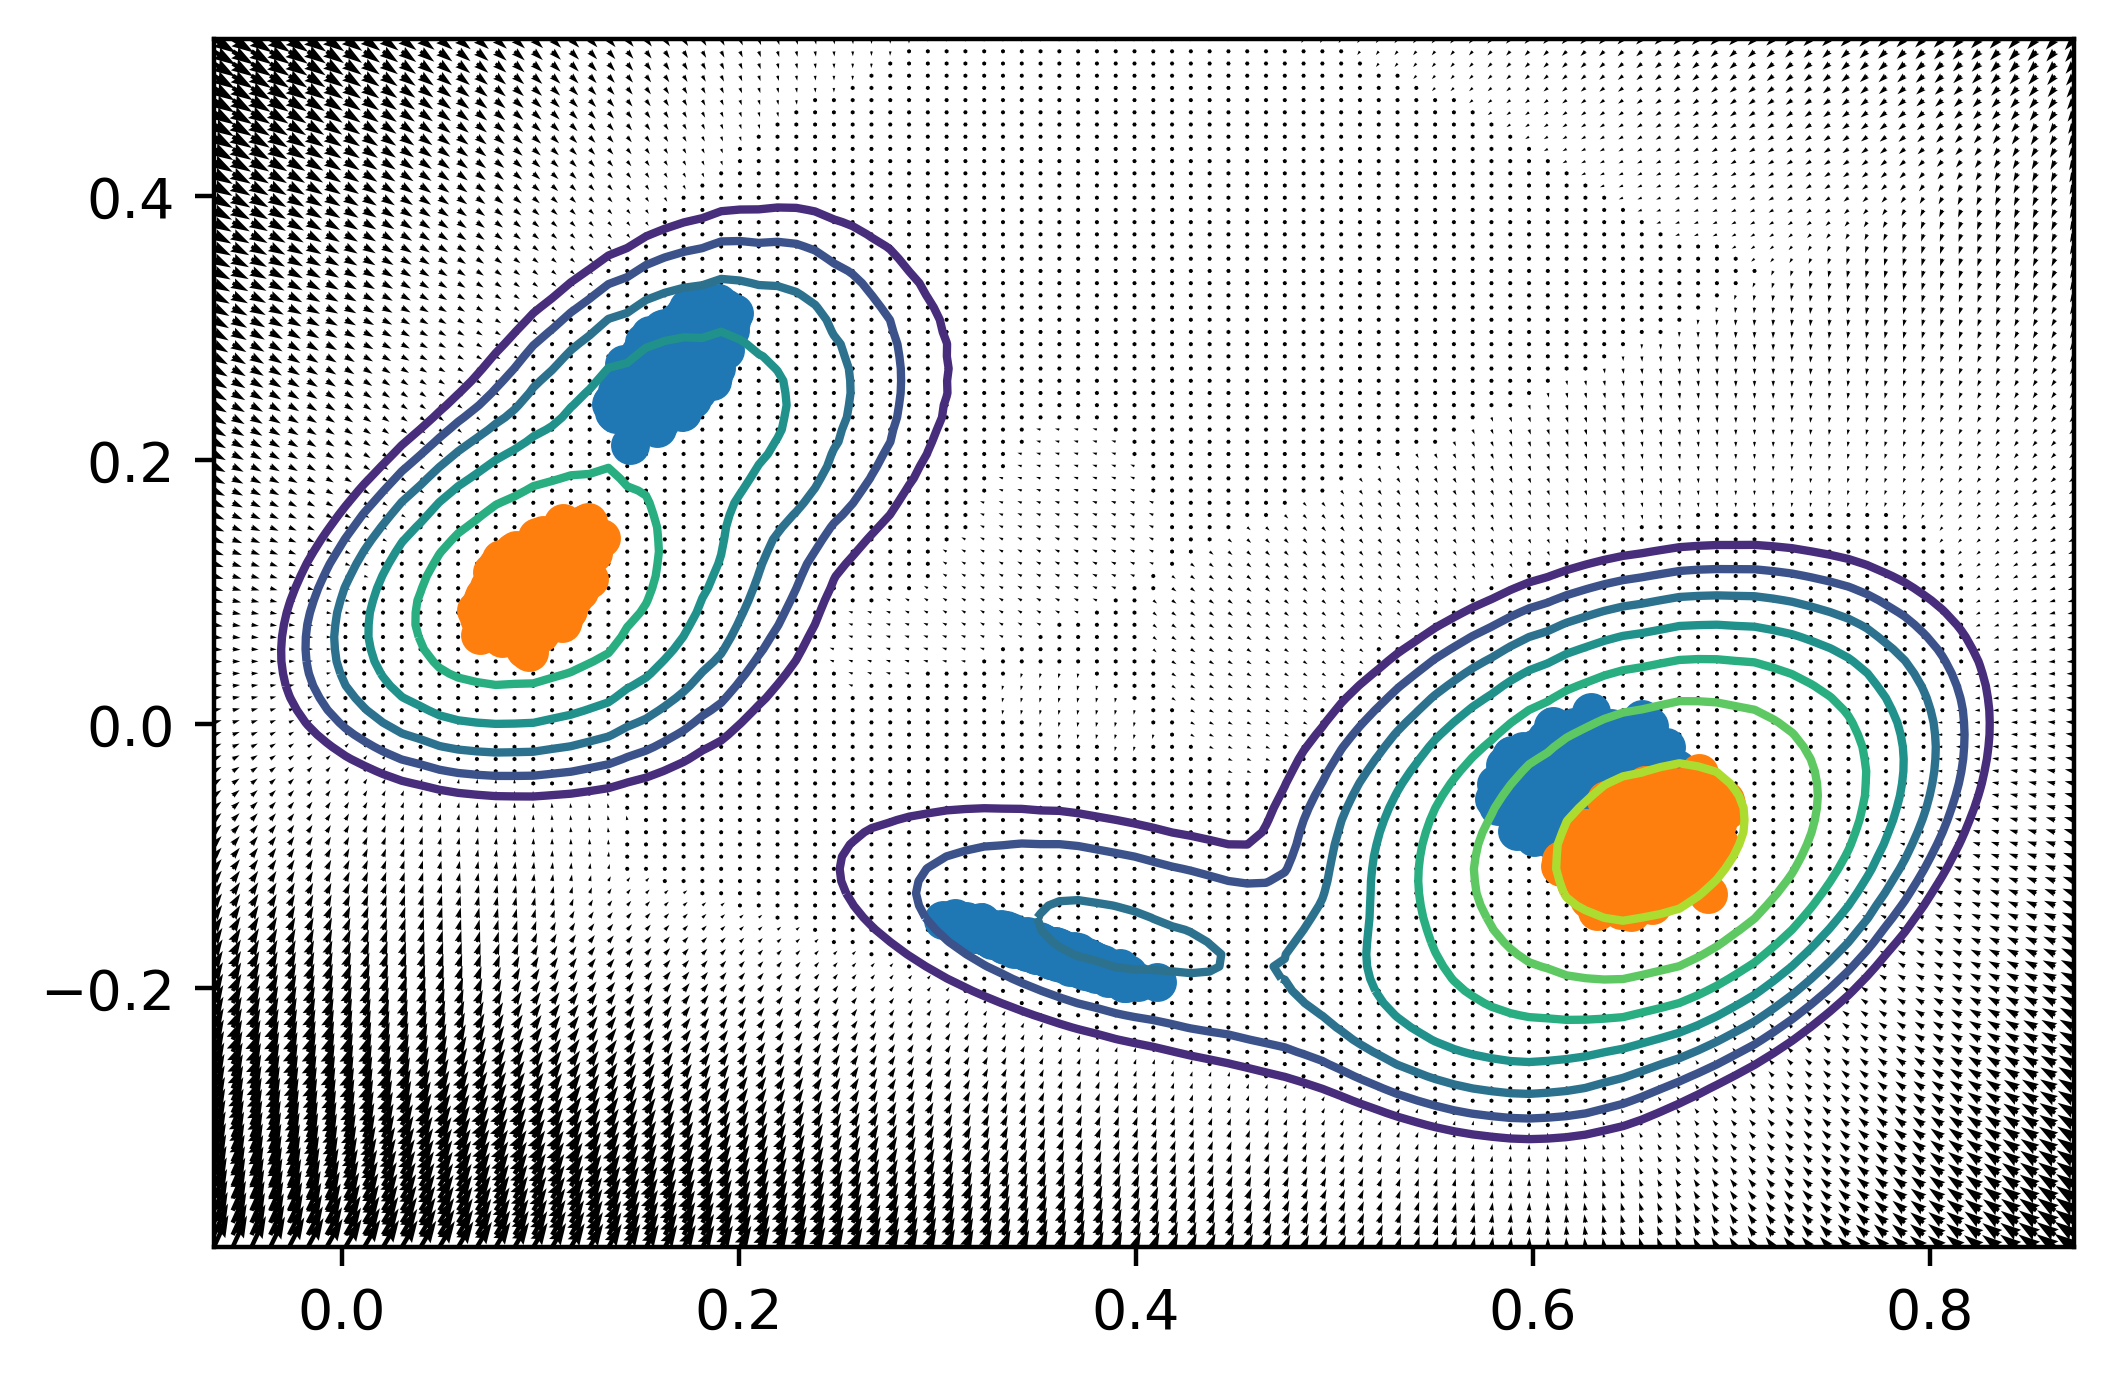

In [5]:
plt.figure(dpi = 400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1],torch.log(myRBM.p_m.cpu()))
plt.scatter(proj_data.cpu()[:,0], proj_data.cpu()[:,1])
plt.scatter(proj_gen[:,0], proj_gen[:,1])

In [6]:
myRBM.W.shape

torch.Size([100, 1000])